# EDA 2: Stastistical exploration
After the  analysis from football standpoint, we will move on to a more statistical analysis of the problem with the purpose of finishing defining the strategy that was thought of with the analysis of the problem.

It is needed to recall that it the proposed benchmark model is a logistic regression model that can be tested vs a Random Forest, a XGB and a NN models. Therefore in orders for the model to work properly we need to ensure some assumptions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Import custom functions
import sys
sys.path.append('data/')
import funciones

def load_data(file_path):
    """
    Load data from a pickle file.
    
    Parameters:
    file_path (str): Path to the pickle file.
    
    Returns:
    pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_pickle(file_path)

def dqr_summary(data):
    """
    Generate and print Data Quality Report.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    """
    dqr = funciones.dqr(data)
    print(tabulate(dqr, headers='keys', tablefmt='pretty', showindex=False))

def conteo_por_tipo_de_dato(data):
    """
    Count variables by data type.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    
    Returns:
    pd.Series: Series with counts of each data type.
    """
    return data.dtypes.value_counts()

def find_boundaries(df_var, distance=1.5):
    """
    Find IQR-based boundaries for a variable.
    
    Parameters:
    df_var (pd.Series): Input variable.
    distance (float): Multiplier for IQR to determine boundaries.
    
    Returns:
    tuple: Lower and upper boundaries.
    """
    IQR = df_var.quantile(0.75) - df_var.quantile(0.25)
    lower = df_var.quantile(0.25) - IQR * distance
    upper = df_var.quantile(0.75) + IQR * distance
    return lower, upper

def find_outliers(df, cont_columns):
    """
    Identify outliers in continuous variables based on IQR.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    cont_columns (list): List of continuous variable names.
    
    Returns:
    np.ndarray: Boolean array indicating rows without outliers.
    """
    cleaned_indices = np.ones(len(df), dtype=bool)
    for col in cont_columns:
        lower_bound, upper_bound = find_boundaries(df[col])
        cleaned_indices &= (df[col] >= lower_bound) & (df[col] <= upper_bound)
    return cleaned_indices

def clean_outliers(df, cleaned_indices):
    """
    Remove outliers from DataFrame based on cleaned indices.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    cleaned_indices (np.ndarray): Boolean array indicating rows without outliers.
    
    Returns:
    pd.DataFrame: DataFrame without outliers.
    """
    return df[cleaned_indices]

def calculate_vif(data, numerical_vars):
    """
    Calculate and print Variance Inflation Factor (VIF) for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif_data = pd.DataFrame()
    vif_data['Variable'] = numerical_vars
    vif_data['VIF'] = [variance_inflation_factor(data[numerical_vars].values, i) for i in range(len(numerical_vars))]

    print(tabulate(vif_data, headers='keys', tablefmt='pretty', showindex=False))

def interpret_vif(vif):
    """
    Interpret Variance Inflation Factor (VIF) value.
    
    Parameters:
    vif (float): VIF value.
    
    Returns:
    str: Interpretation of VIF value.
    """
    if vif < 4:
        return 'No collinearity'
    elif 4 <= vif <= 10:
        return 'Deeper analysis needed'
    else:
        return 'Collinearity detected'

def plot_histograms(data, numerical_vars):
    """
    Plot histograms for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    """
    num_vars = len(numerical_vars)
    num_rows = (num_vars + 1) // 2
    fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, num_rows * 3))

    for i, var in enumerate(numerical_vars):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        data[var].hist(bins=20, ax=ax)
        ax.set_title(var)

    if num_vars % 2 != 0:
        fig.delaxes(axs[num_rows - 1, 1])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.5)
    plt.suptitle('Histograms for Continuous Variables', fontsize=16)
    plt.show()

def plot_class_distribution(data, target_var):
    """
    Plot bar chart for class distribution of the target variable.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    target_var (str): Target variable name.
    """
    class_dist = data[target_var].value_counts()
    ax = class_dist.plot(kind='bar')
    plt.title('Balance Test of Predicted Variable')
    plt.xticks(rotation=0)
    plt.tight_layout()

    for i, value in enumerate(class_dist):
        ax.text(i, value, str(value), ha='center', va='bottom')

    plt.show()

def plot_boxplots(data, numerical_vars):
    """
    Plot boxplots for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    """
    plt.figure(figsize=(12, 8))
    num_rows = (len(numerical_vars) + 1) // 2

    for i, var in enumerate(numerical_vars, start=1):
        plt.subplot(num_rows, 2, i)
        sns.boxplot(x=data[var])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.5)
    plt.suptitle('Boxplot Analysis', fontsize=16)
    plt.show()

def plot_scales(data, numerical_vars, variable_units):
    """
    Plot scales (min and max values) for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    variable_units (dict): Dictionary mapping variables to their units.
    """
    min_values = data[numerical_vars].min()
    max_values = data[numerical_vars].max()

    plt.figure(figsize=(12, 8))
    num_rows = len(numerical_vars) // 2 + len(numerical_vars) % 2

    for i, var in enumerate(numerical_vars, start=1):
        unit = variable_units[var]
        plt.subplot(num_rows, 2, i)
        plt.bar(['Min', 'Max'], [min_values[var], max_values[var]], color=['blue', 'orange'])
        plt.title(var)
        plt.ylabel(unit)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.25)
    plt.suptitle('Scales Analysis', fontsize=16)
    plt.show()

def plot_correlation_matrix(data, numerical_vars):
    """
    Plot correlation matrix for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    """
    corr_matrix = data[numerical_vars].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()

## DQR
We staart the analysis with a quick visual summary of the variables.

In [2]:
data_file = "data/fourth_down_data.pkl"
raw_data = load_data(data_file)

dqr_summary(raw_data)

+------------------------+----------+----------------+----------------+---------------+------------+---------------+
|         Names          |   Type   | Missing_values | Present_values | Unique_values | Min_value  |   Max_value   |
+------------------------+----------+----------------+----------------+---------------+------------+---------------+
|      yardline_100      | float32  |       0        |      2764      |      96       |    1.0     |     97.0      |
|      posteam_type      |  object  |       0        |      2764      |       2       |    away    |     home      |
| half_seconds_remaining | float32  |       0        |      2764      |     1216      |    1.0     |    1759.0     |
|       game_half        |  object  |       0        |      2764      |       3       |   Half1    |   Overtime    |
|       goal_to_go       |  int32   |       0        |      2764      |       2       |     0      |       1       |
|        ydstogo         | float32  |       0        |      2764

From the qualitative report of the data, we can, first of all, obtain the following categorization of the variables.

*Categorical variables:
- postteam_type
- game_half
- play_type
- play_location
- play_subtype
-yardline_group

*Numerical variables:
-yardline_100
- half_seconds_remaining
- ydstogo
- ydsnet
- score_differential

*Binary variables
- goal_to_go
-shotgun
- no_huddle
- qb_dropback

We can also observe the difference in the units of measurements and magnitudes within these scales, this is not a small issue as for NN big differences in the scale can cause saturation. Another thing that we ensure with the report is the non-presence of null values ​​and the size of the problem that is important for the selection of the model.

In [3]:
# Feature clustering
categorical_vars = ['posteam_type', 'game_half', 'play_type', 'play_location', 'play_subtype', 'yardline_group']
numerical_vars = ['yardline_100', 'half_seconds_remaining', 'ydstogo', 'ydsnet', 'score_differential']
binary_vars = ['goal_to_go', 'shotgun', 'no_huddle', 'qb_dropback']
target_var = 'fourth_down_converted'

## Model assumptions
From the models selected, these are the tests needed to fit the model's assumptions.

### Data distribution
None of the 3 models assumes a normal distribution. However, the models can be sensitive to the presence of outliers. Therefore, we will try to eliminate outliers which in itself will help the distribution of the data.

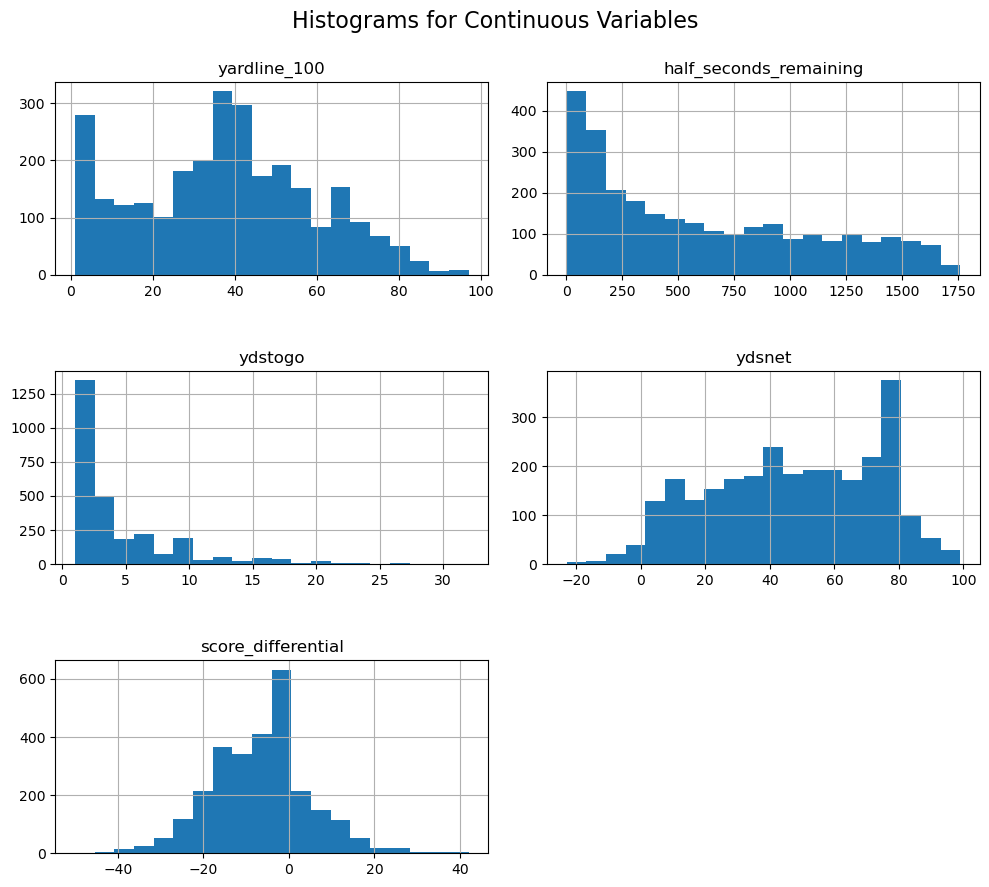

In [4]:
plot_histograms(raw_data, numerical_vars)

We can observe quasi-uniform and normal distributions for the variables: score differential, ydsnet & yardline_100. For the ydstogo variable (main variable of the model) we see a clear presence of outliers, we know from empirical domain that the majority of your data should be between 1-10 yards all observations outside that range, perhaps up to 1-10 yards. 15, should be eliminated from the model. For the last variable, time, it was already mentioned in the exploration of the problem that it is intended to treat observations with less time on the clock different from the model data because they assume a different assumption of occurrence than the others.

### Distribution of the class to be predicted
An important assumption, especially for tree-based models, is that of class balancing; models based on decision trees usually give attention to the dominant class in the face of unbalanced sets. If the set is not balanced (maximum unbalance ratio of 60/40) balancing techniques such as SMOTE will be applied.

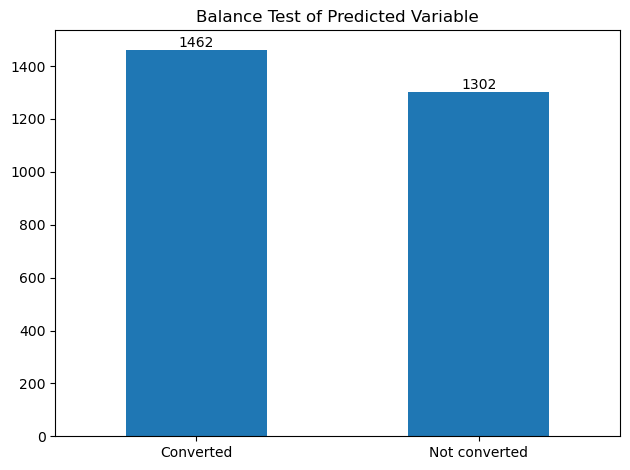

In [5]:
plot_class_distribution(raw_data, target_var)

Fortunately, we can see that for our problem the class to be predicted has an almost perfect balance.

### Atypical values
We will use a box analysis to determine the presence of outliers, as we already mentioned during the study of the normality assumption, the variable ydstogo has several outlier records that we plan to eliminate.

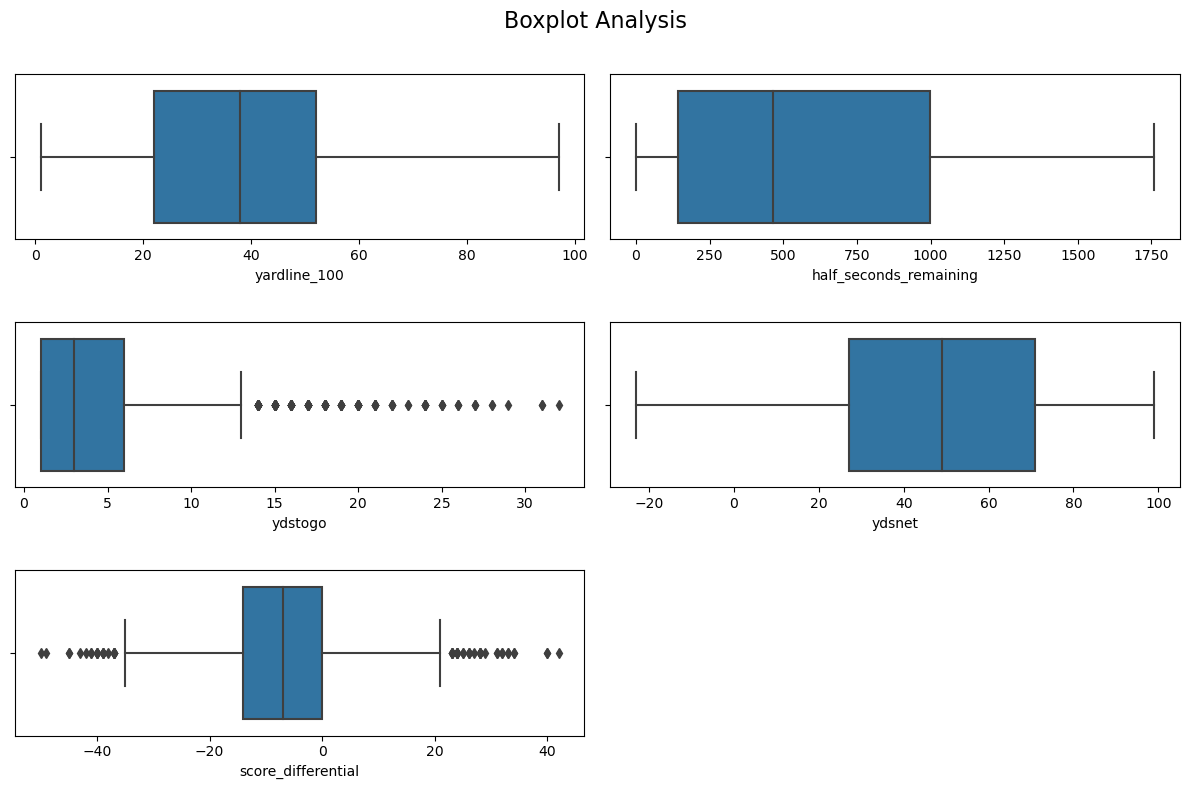

In [6]:
plot_boxplots(raw_data, numerical_vars)

### Data scale
Probably the most important assumption for the models is the scale of the data; in SVM models or neural models, non-scaling can lead to convergence at a local minimum, saturation, among others.

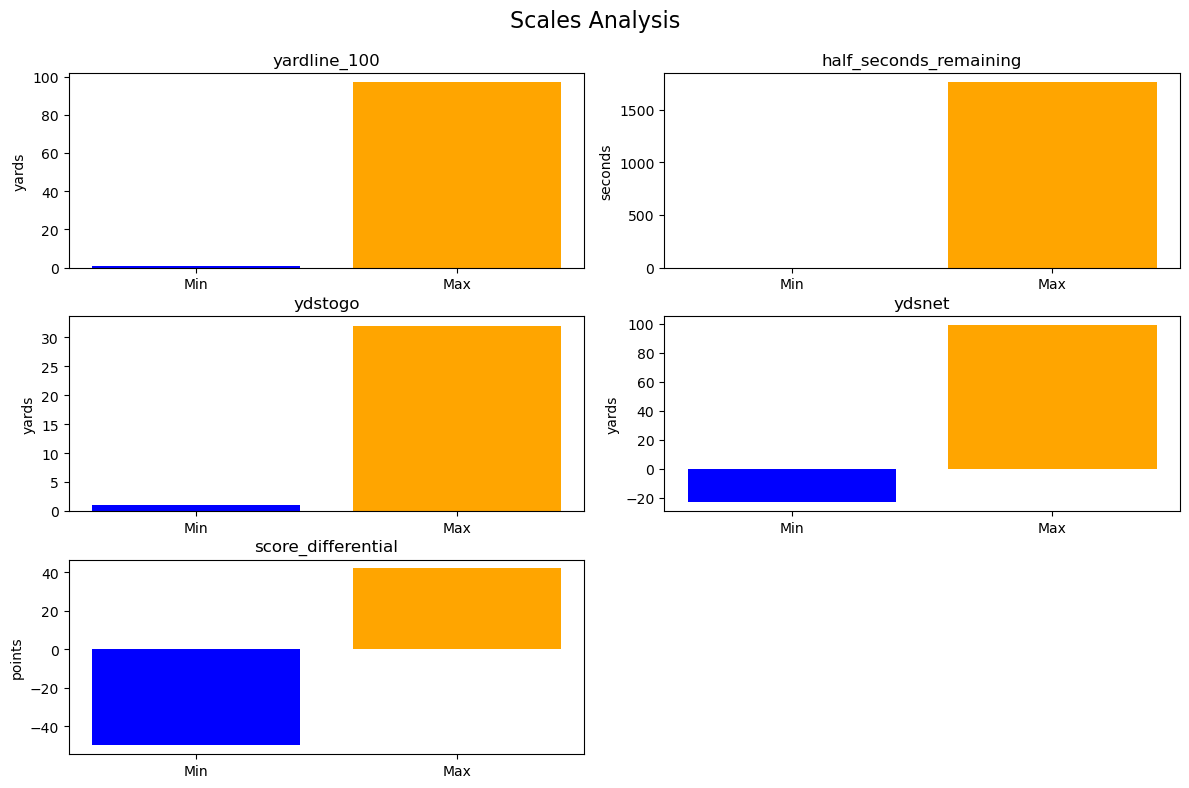

In [7]:
variable_units = {
        'yardline_100': 'yards',
        'half_seconds_remaining': 'seconds',
        'ydstogo': 'yards',
        'ydsnet': 'yards',
        'score_differential': 'points'
    }

plot_scales(raw_data, numerical_vars, variable_units)

We can observe, in effect, both the different units of measurement (points, yards, seconds) and the differences in the magnitudes of these variables, even in those that share measurement units. So, as we knew we will have to use data scaling techniques, given the distributions (which do not assume an assumption of normality) and given the fact that we will remove outliers we could think that standardization (subtracting its mean and dividing it by the standard deviation) could be an optimal method for scaling, although for interpretability issues perhaps a minmax normalization could work better.

### Collinearity
Basic assumption for any linear model (such as logistic regression), through a correlation matrix we can identify collinearity between the elements of the feature space.

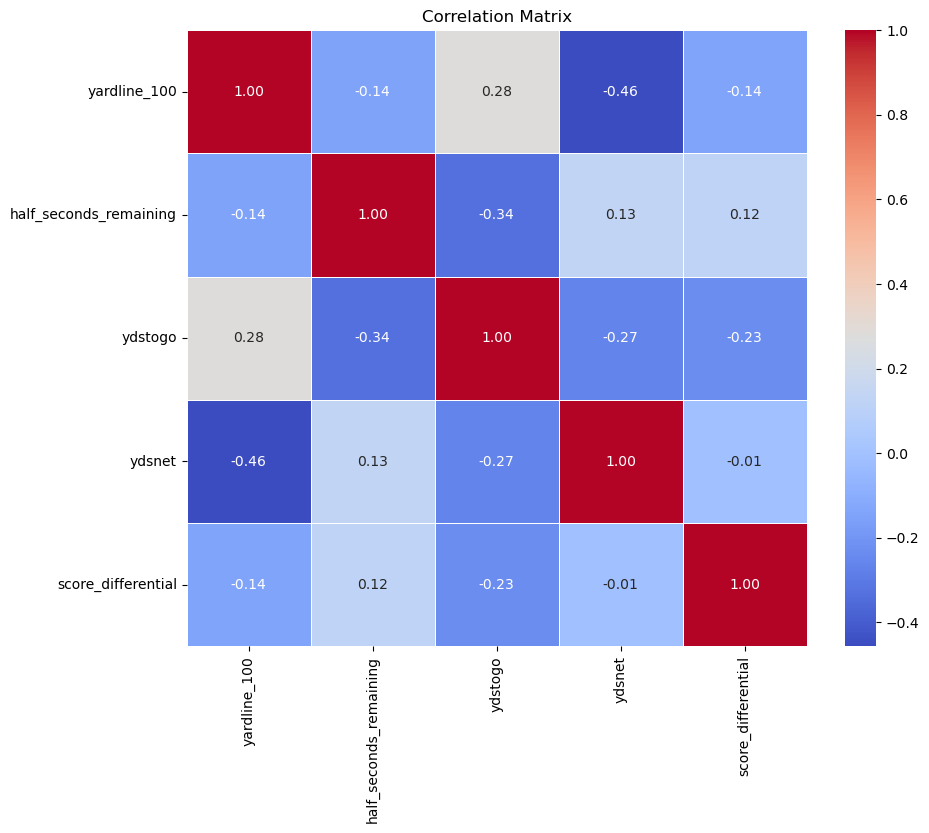

+------------------------+--------------------+
|        Variable        |        VIF         |
+------------------------+--------------------+
|      yardline_100      | 2.942307093671298  |
| half_seconds_remaining | 2.323826295493626  |
|        ydstogo         | 2.1483241411503906 |
|         ydsnet         | 2.567721068609398  |
|   score_differential   | 1.4422873693720288 |
+------------------------+--------------------+


In [8]:
plot_correlation_matrix(raw_data, numerical_vars)
calculate_vif(raw_data, numerical_vars)

We can observe with the VIF matrix (Variance Inflation Factor) that all indices are less than 5 suggesting there is no evidence of collinearity between the variables.

## Second conclusions
After statistical analysis of the data. We can conclude that the pre-selected models, after pre-processing the data, are models that may fit the problem. We also conclude that we need to eliminate some outliers as well as apply data scaling to be able to work with the models.

Since we have categorical variables and the feature space for continuous variables always handles the same range of values, it sounds to me that a tree-based model (probably Random Forest, enhanced with XGBoost) could be the one with the best results and we can even take advantage to its feature importance modules to obtain a more solid overview of the variables that are most influencing the success or failure of plays.